In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
import warnings
%matplotlib inline

warnings.filterwarnings('ignore')

In [8]:
df = pd.read_csv(r'data/train.csv')
df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [10]:
#Removing Twitter handles 
def remove_pattern(ip,pattern):
    r = re.findall(pattern,ip)
    for word in r:
        ip = re.sub(word,"",ip)
    return ip 
df['clean'] = np.vectorize(remove_pattern)(df['tweet'],'@[\w]*')
df.head()

,id,label,tweet,clean
0,1,0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so sel...
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can't use cause th...
2,3,0,bihday your majesty,bihday your majesty
3,4,0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation,factsguide: society now #motivation


In [11]:
def clean_text(text):
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    text = re.sub(r'https?://\S+', '', text)
    text = re.sub(r'[^A-Za-z0-9\s#]', '', text)
    text = text.encode('ascii', 'ignore').decode()
    return text

df['clean'] = df['clean'].apply(lambda x: " ".join([w for w in clean_text(x).split() if len(w) > 3]))
# Display the cleaned data
df.head()

,id,label,tweet,clean
0,1,0,@user when a father is dysfunctional and is s...,when father dysfunctional selfish drags kids i...
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks #lyft credit cant cause they dont offer...
2,3,0,bihday your majesty,bihday your majesty
3,4,0,#model i love u take with u all the time in ...,#model love take with time
4,5,0,factsguide: society now #motivation,factsguide society #motivation


In [12]:
#Tokeninzing individual words
tokenized_tweet = df['clean'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [when, father, dysfunctional, selfish, drags, ...
1    [thanks, #lyft, credit, cant, cause, they, don...
2                              [bihday, your, majesty]
3                     [#model, love, take, with, time]
4                   [factsguide, society, #motivation]
Name: clean, dtype: object

In [13]:
#stemming the words
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()
tokenized_tweet = tokenized_tweet.apply(lambda sentence: [stemmer.stem(word) for word in sentence])

# combine words into single sentence
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = " ".join(tokenized_tweet[i])
    
df['clean'] = tokenized_tweet
df.head()

,id,label,tweet,clean
0,1,0,@user when a father is dysfunctional and is s...,when father dysfunct selfish drag kid into dys...
1,2,0,@user @user thanks for #lyft credit i can't us...,thank #lyft credit cant caus they dont offer w...
2,3,0,bihday your majesty,bihday your majesti
3,4,0,#model i love u take with u all the time in ...,#model love take with time
4,5,0,factsguide: society now #motivation,factsguid societi #motiv


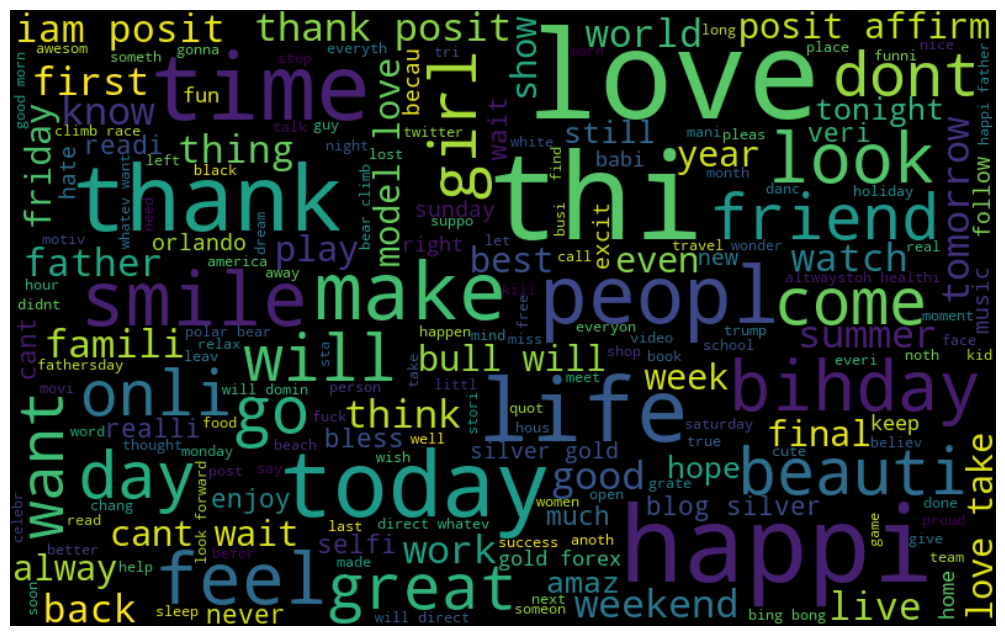

In [15]:
#performing EDA
from wordcloud import WordCloud as WC
all_words = " ".join([sentence for sentence in df['clean']])
wc = WC(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)
plt.figure(figsize=(15,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

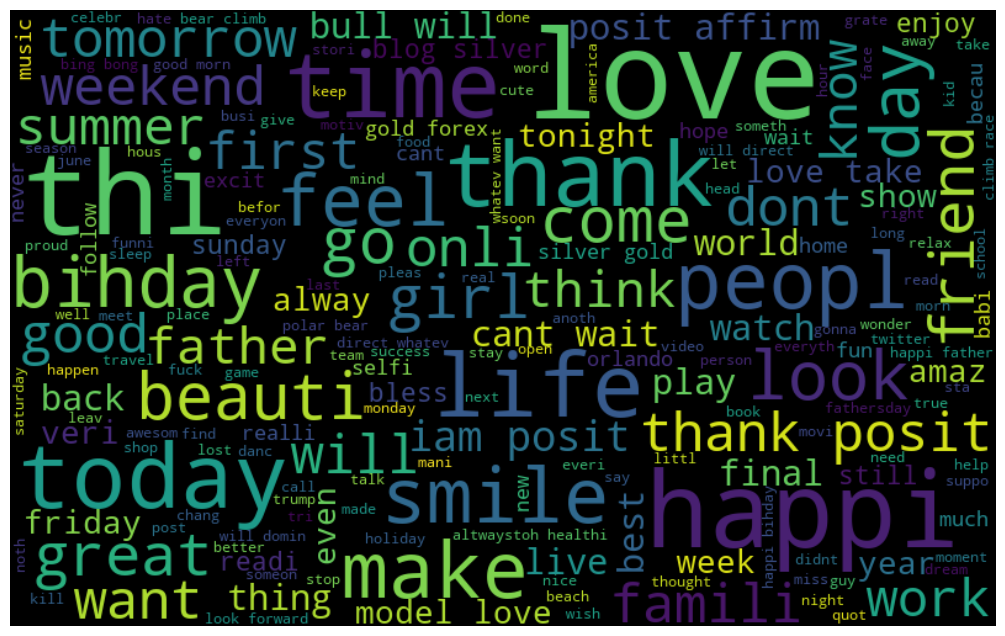

In [16]:
# frequent words visualization for +ve
all_words = " ".join([sentence for sentence in df['clean'][df['label']==0]])

wc = WC(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

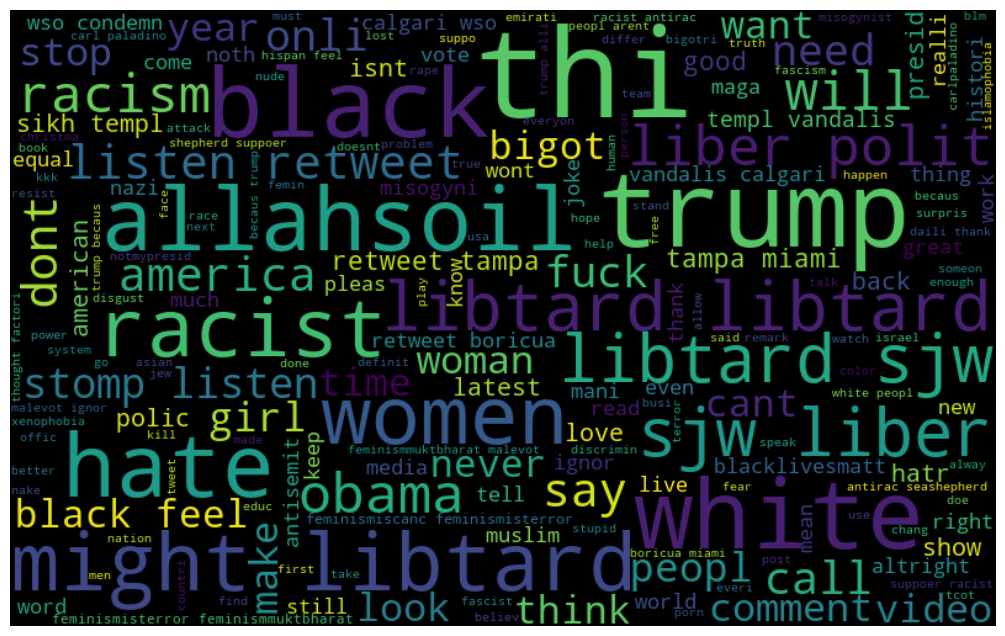

In [17]:
# frequent words visualization for -ve
all_words = " ".join([sentence for sentence in df['clean'][df['label']==1]])

wc = WC(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

plt.figure(figsize=(15,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [18]:
# extract the hashtag
def hashtag_extract(tweets):
    hashtags = []
    # loop words in the tweet
    for tweet in tweets:
        ht = re.findall(r"#(\w+)", tweet)
        hashtags.append(ht)
    return hashtags

# extract hashtags from +ve tweets
ht_positive = hashtag_extract(df['clean'][df['label']==0])

# extract hashtags from -ve tweets
ht_negative = hashtag_extract(df['clean'][df['label']==1])

In [19]:
ht_positive[:5]

[['run'], ['lyft', 'disapoint', 'getthank'], [], ['model'], ['motiv']]

In [20]:
# unnest list
ht_positive = sum(ht_positive, [])
ht_negative = sum(ht_negative, [])

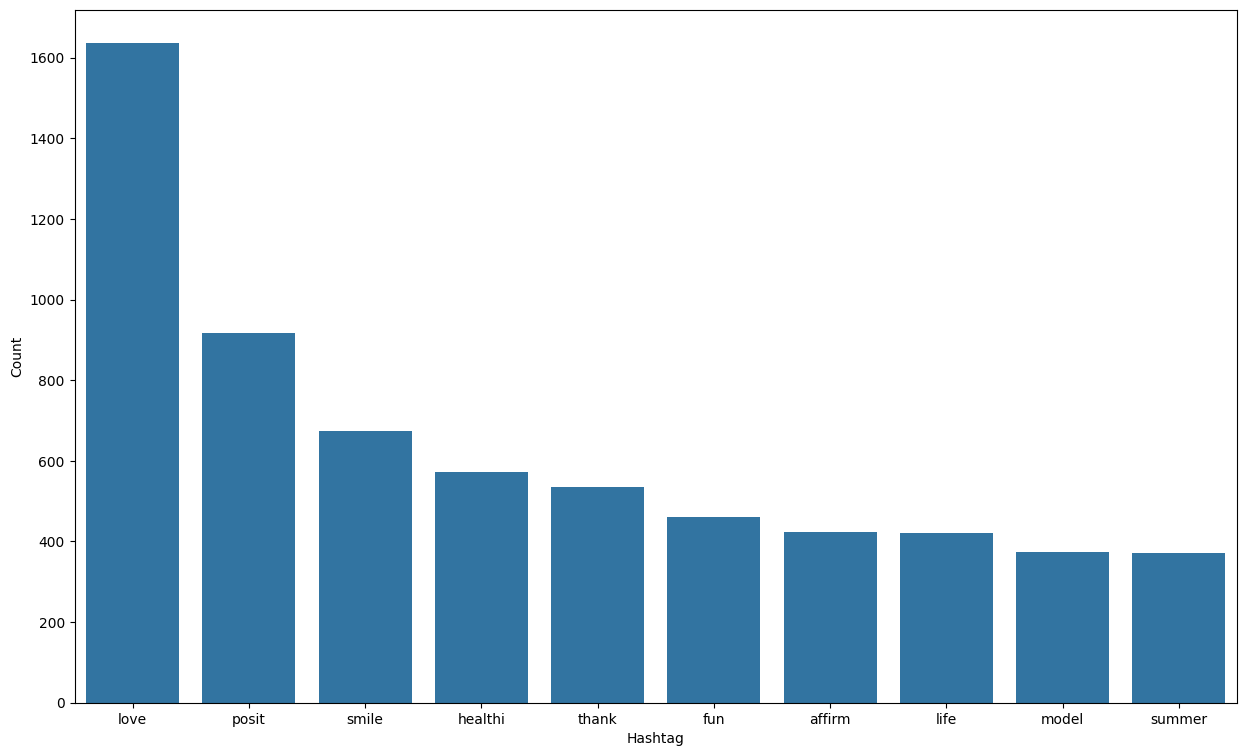

In [21]:
# Top Hashtags from +ve
freq = nltk.FreqDist(ht_positive)
d = pd.DataFrame({'Hashtag': list(freq.keys()),
                 'Count': list(freq.values())})

# select top 10 hashtags
d = d.nlargest(columns='Count', n=10)
plt.figure(figsize=(15,9))
sns.barplot(data=d, x='Hashtag', y='Count')
plt.show()

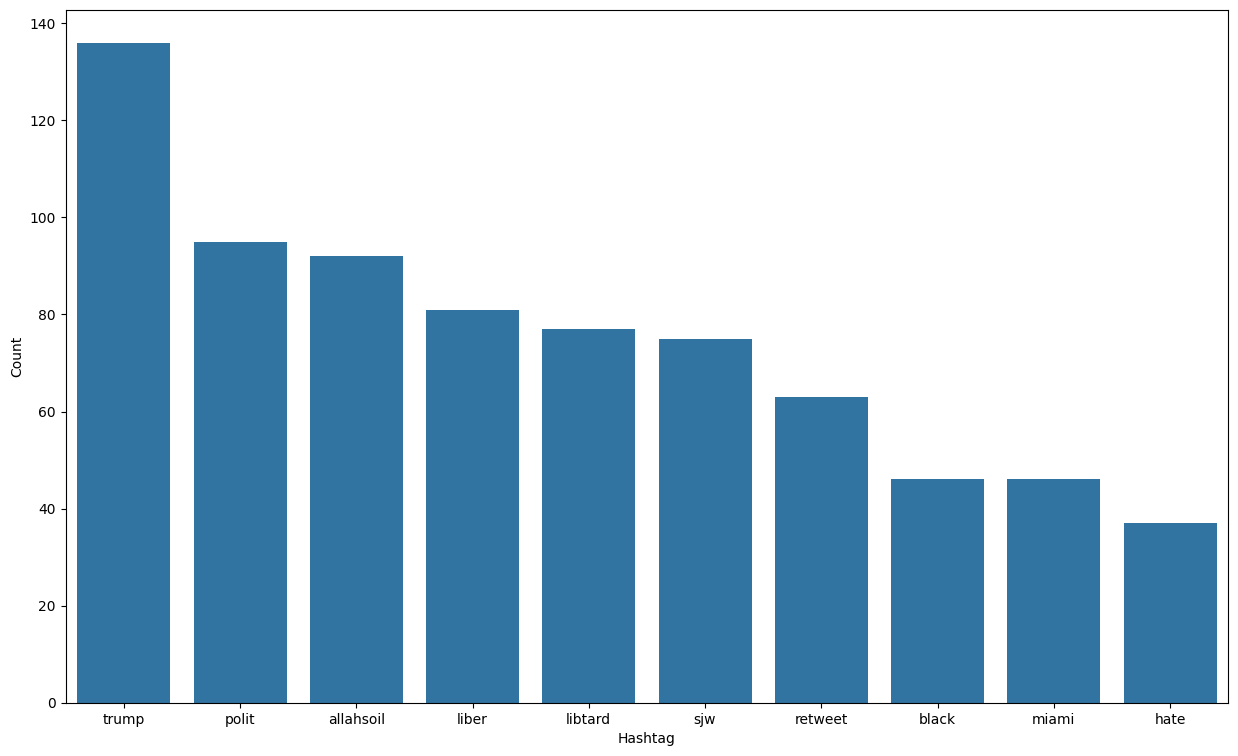

In [22]:
# Top hashtags from -ve
freq = nltk.FreqDist(ht_negative)
d = pd.DataFrame({'Hashtag': list(freq.keys()),
                 'Count': list(freq.values())})
d.head()

# select top 10 hashtags
d = d.nlargest(columns='Count', n=10)
plt.figure(figsize=(15,9))
sns.barplot(data=d, x='Hashtag', y='Count')
plt.show()


In [26]:
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
bow = bow_vectorizer.fit_transform(df['clean'])

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(bow, df['label'], random_state=42, test_size=0.25)

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score

# training
model = LogisticRegression()
model.fit(x_train, y_train)

LogisticRegression()

In [28]:
pred = model.predict(x_test)
print('F1score :',f1_score(y_test,pred))
print('Accuracy :', accuracy_score(y_test,pred))

F1score : 0.5071428571428571
Accuracy : 0.9481917156801402


In [29]:
td = pd.read_csv(r'data/test.csv')
td['clean'] = np.vectorize(remove_pattern)(td['tweet'],'@[\w]*')
td['clean'] = td['clean'].apply(lambda x: " ".join([w for w in clean_text(x).split() if len(w) > 3]))
td.head()

,Unnamed: 0,id,tweet,clean
0,0,31963,#studiolife #aislife #requires #passion #dedic...,#studiolife #aislife #requires #passion #dedic...
1,1,31964,@user #white #supremacists want everyone to s...,#white #supremacists want everyone #birds #mov...
2,2,31965,safe ways to heal your #acne!! #altwaystohe...,safe ways heal your #acne #altwaystoheal #heal...
3,3,31966,is the hp and the cursed child book up for res...,cursed child book reservations already where w...
4,4,31967,"3rd #bihday to my amazing, hilarious #nephew...",#bihday amazing hilarious #nephew ahmir uncle ...


In [30]:
tokenized_tweet = td['clean'].apply(lambda x: x.split())
tokenized_tweet = tokenized_tweet.apply(lambda sentence: [stemmer.stem(word) for word in sentence])
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = " ".join(tokenized_tweet[i])
td['clean'] = tokenized_tweet
td.head()

,Unnamed: 0,id,tweet,clean
0,0,31963,#studiolife #aislife #requires #passion #dedic...,#studiolif #aislif #requir #passion #dedic #wi...
1,1,31964,@user #white #supremacists want everyone to s...,#white #supremacist want everyon #bird #movi here
2,2,31965,safe ways to heal your #acne!! #altwaystohe...,safe way heal your #acn #altwaystoh #healthi #...
3,3,31966,is the hp and the cursed child book up for res...,curs child book reserv alreadi where when #har...
4,4,31967,"3rd #bihday to my amazing, hilarious #nephew...",#bihday amaz hilari #nephew ahmir uncl dave lo...


In [31]:
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
bow = bow_vectorizer.fit_transform(td['clean'])

Xtest= bow
pred = model.predict(Xtest)

In [32]:
print("Predictions:")
for i, p in enumerate(pred):
    print(f"Tweet {i+1}: {p}")

Predictions:
Tweet 1: 0
Tweet 2: 0
Tweet 3: 0
Tweet 4: 0
Tweet 5: 0
Tweet 6: 0
Tweet 7: 0
Tweet 8: 0
Tweet 9: 0
Tweet 10: 0
Tweet 11: 0
Tweet 12: 0
Tweet 13: 0
Tweet 14: 0
Tweet 15: 0
Tweet 16: 0
Tweet 17: 0
Tweet 18: 0
Tweet 19: 0
Tweet 20: 0
Tweet 21: 0
Tweet 22: 0
Tweet 23: 0
Tweet 24: 0
Tweet 25: 0
Tweet 26: 0
Tweet 27: 0
Tweet 28: 0
Tweet 29: 0
Tweet 30: 0
Tweet 31: 0
Tweet 32: 0
Tweet 33: 0
Tweet 34: 1
Tweet 35: 0
Tweet 36: 0
Tweet 37: 0
Tweet 38: 0
Tweet 39: 1
Tweet 40: 0
Tweet 41: 0
Tweet 42: 0
Tweet 43: 0
Tweet 44: 0
Tweet 45: 0
Tweet 46: 0
Tweet 47: 0
Tweet 48: 0
Tweet 49: 1
Tweet 50: 0
Tweet 51: 0
Tweet 52: 0
Tweet 53: 0
Tweet 54: 0
Tweet 55: 0
Tweet 56: 0
Tweet 57: 0
Tweet 58: 0
Tweet 59: 0
Tweet 60: 0
Tweet 61: 0
Tweet 62: 0
Tweet 63: 0
Tweet 64: 1
Tweet 65: 0
Tweet 66: 0
Tweet 67: 0
Tweet 68: 0
Tweet 69: 0
Tweet 70: 0
Tweet 71: 0
Tweet 72: 0
Tweet 73: 1
Tweet 74: 0
Tweet 75: 0
Tweet 76: 0
Tweet 77: 0
Tweet 78: 0
Tweet 79: 0
Tweet 80: 0
Tweet 81: 0
Tweet 82: 0
Tweet 83: 0
